# ssp.train.py

In [57]:
import torch   
import torch.nn as nn 
import torch.nn.functional as F   
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from scipy import io
import itertools
import math
import datetime
import wandb
import pickle
import json
import time
import sys
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from scipy.optimize import linear_sum_assignment
from snntorch import spikegen
from sklearn.manifold import TSNE


# my module import
from modules import *

# os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

# modules 폴더에 새모듈.py 만들면
# modules/__init__py 파일에 form .새모듈 import * 하셈
# 그리고 새모듈.py에서 from modules.새모듈 import * 하셈

In [58]:

data_path = ["/data2/spike_sorting/neuropixels_choi/set1/winner_data_all_45000001_60000000.mat",
                "/data2/spike_sorting/neuropixels_choi/set2/winner_data_all_45000001_60000000.mat",
                "/data2/spike_sorting/neuropixels_choi/set3/winner_data_all_45000001_60000000.mat",]
label_path = ["/data2/spike_sorting/neuropixels_choi/set1/label_all_45000001_60000000.mat",
                "/data2/spike_sorting/neuropixels_choi/set2/label_all_45000001_60000000.mat",
                "/data2/spike_sorting/neuropixels_choi/set3/label_all_45000001_60000000.mat",]

AE_train_data_path = "/data2/spike_sorting/neuropixels_choi/winner_data_all_1_45000000.mat" # gt
AE_train_label_path = "/data2/spike_sorting/neuropixels_choi/label_all_1_45000000.mat" # gt

# high_data_path = AE_train_data_path     # AE_train_data_path # data_path[0]
# high_label_path = AE_train_label_path     # AE_train_label_path # label_path[0]
# high_data_path = data_path[0]
# high_label_path = label_path[0]
# high_data_path = data_path[1]
# high_label_path = label_path[1]
high_data_path = data_path[2]
high_label_path = label_path[2]

data = torch.tensor(io.loadmat(high_data_path)['winner_data_all']).float()
label = torch.tensor(io.loadmat(high_label_path)['label_all']).float()
print(label.shape) #torch.Size([88461, 8])

unit = label[:, 0].to(torch.int)
ch = label[:, 1].to(torch.int)
start = label[:, 2].to(torch.int)
end = label[:, 3].to(torch.int)
gt = label[:, 4].to(torch.int)
max_slope_index = label[:, 5].to(torch.int)
ch_winner_determinant = label[:, 6]
set_idx = label[:, 7].to(torch.int)

torch.Size([3985, 8])


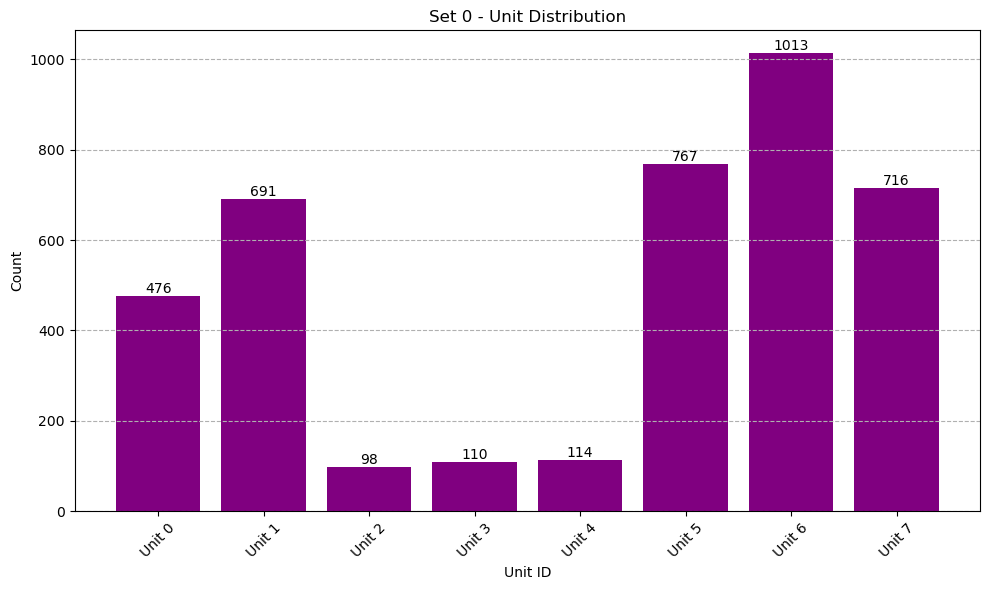

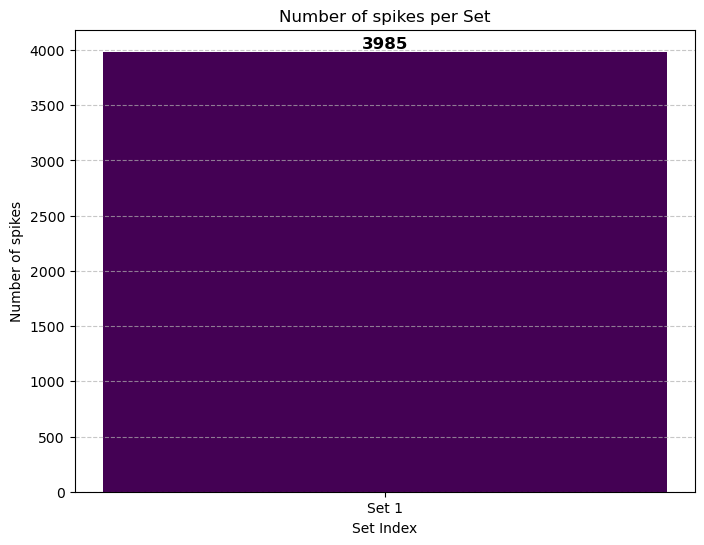

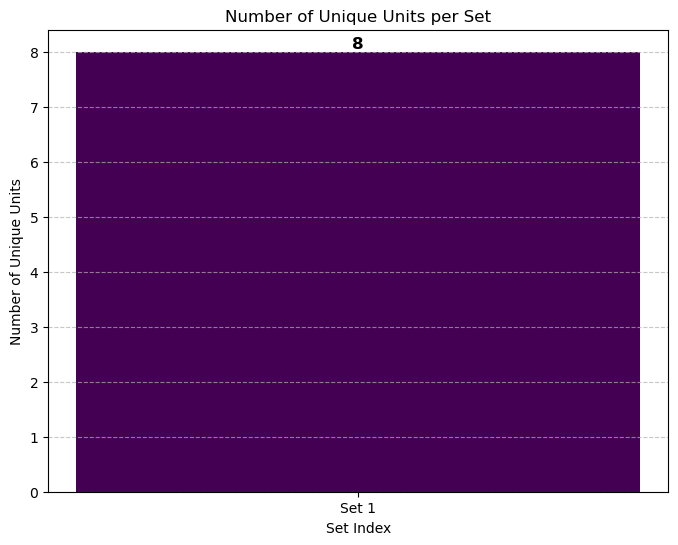

In [59]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# 전체 unit 리스트 (모든 set에서 등장한 unit을 포함)
all_units = sorted(torch.unique(unit).tolist())  

# 고유한 set_idx 가져오기
unique_set_idx = torch.unique(set_idx).tolist()

# 원하는 색상을 순서대로 정의 (보라색, 청록색, 노란색)
custom_colors = ListedColormap(['#800080', '#40E0D0', '#FFFF00'])  # 보라색, 청록색, 노란색

for i, idx in enumerate(unique_set_idx):
    # 해당 set_idx에 속한 unit 값들 추출
    units_in_set = unit[set_idx == idx]

    # unit별 개수 세기 (없는 unit은 count=0)
    unit_counts = {u: 0 for u in all_units}  # 모든 unit을 포함한 딕셔너리
    unique_units, counts = torch.unique(units_in_set, return_counts=True)
    for u, c in zip(unique_units.tolist(), counts.tolist()):
        unit_counts[u] = c  # 실제 unit count 적용

    # X축 unit, Y축 count 데이터 준비
    x_labels = [f"Unit {u}" for u in all_units]
    y_values = list(unit_counts.values())

    # 색상 선택 (custom_colors에서 순차적으로 색상 선택)
    color = custom_colors(i / len(unique_set_idx))  # 비율을 기준으로 색상 선택

    # 새로운 플롯 생성
    plt.figure(figsize=(10, 6))
    bars = plt.bar(all_units, y_values, color=color, alpha=1.0)

    # 각 막대 위에 숫자 표시
    for bar in bars:
        height = bar.get_height()
        if height > 0:  # 값이 있는 경우에만 표시
            plt.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom', fontsize=10)

    # X축, Y축 설정
    plt.ylabel("Count")
    plt.title(f"Set {idx} - Unit Distribution")
    plt.grid(axis="y", linestyle="--", alpha=1.0)
    plt.xticks(all_units, [f"Unit {u}" for u in all_units], rotation=45)  # X축 레이블 "Unit 0", "Unit 1" 형태로 표시

    # X축 레이블 추가
    plt.xlabel("Unit ID")

    # 플롯 표시
    plt.tight_layout()
    plt.show()


# set_idx 추출
set_idx = (label[:, 7] + 1).to(torch.int)  # set index (1 증가)

# set_idx별 label 개수 세기
set_label_counts = {idx: torch.sum(set_idx == idx).item() for idx in torch.unique(set_idx).tolist()}

# X, Y 데이터 준비
set_ids = list(set_label_counts.keys())
label_counts = list(set_label_counts.values())

# 색상 지정
colors = plt.cm.viridis(np.linspace(0, 1, len(set_ids)))

# 그래프 그리기
plt.figure(figsize=(8, 6))
bars = plt.bar(set_ids, label_counts, color=colors, alpha=1.0)

# 막대 위에 숫자 표시
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# 그래프 설정
plt.xlabel("Set Index")
plt.ylabel("Number of spikes")
plt.title("Number of spikes per Set")
plt.xticks(set_ids, [f"Set {s}" for s in set_ids])  # X축 레이블 "Set 1", "Set 2" 형식
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()











# set별 unit 개수 세기
set_unit_counts = {idx: torch.unique(unit[set_idx == idx]).numel() for idx in torch.unique(set_idx).tolist()}

# X, Y 데이터 준비
set_ids = list(set_unit_counts.keys())
unit_counts = list(set_unit_counts.values())

# 색상 지정
colors = plt.cm.viridis(np.linspace(0, 1, len(set_ids)))

# 그래프 그리기
plt.figure(figsize=(8, 6))
bars = plt.bar(set_ids, unit_counts, color=colors, alpha=1.0)

# 막대 위에 숫자 표시
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# 그래프 설정
plt.xlabel("Set Index")
plt.ylabel("Number of Unique Units")
plt.title("Number of Unique Units per Set")
plt.xticks(set_ids, [f"Set {s}" for s in set_ids])  # X축 레이블 "Set 1", "Set 2" 형식
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()
